In [2]:
#https://ichi.pro/pt/segmentacao-de-imagem-com-clustering-198718633488102
#https://github.com/jeongHwarr/various_FCM_segmentation/blob/master/FCM.py
# =============================================================================
# Standard Fuzzy C-means algorithm 
# (https://en.wikipedia.org/wiki/Fuzzy_clustering.)
# =============================================================================

import os
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

Iteration 0 : cost = 491521.392612
Iteration 1 : cost = 10876.208729
Iteration 2 : cost = 42055.203435
Iteration 3 : cost = 112284.839758
Iteration 4 : cost = 171454.944364
Iteration 5 : cost = 186879.987534
Iteration 6 : cost = 133195.903760
Iteration 7 : cost = 80270.107809
Iteration 8 : cost = 42164.599568
Iteration 9 : cost = 22958.645606
Iteration 10 : cost = 15140.539359
Iteration 11 : cost = 11127.342047
Iteration 12 : cost = 8687.967623
Iteration 13 : cost = 6856.955844
Iteration 14 : cost = 5496.022843
Iteration 15 : cost = 4457.470014
Iteration 16 : cost = 3694.320896
Iteration 17 : cost = 3117.916732
Iteration 18 : cost = 2747.404153
Iteration 19 : cost = 2523.620266
Iteration 20 : cost = 2337.841155
Iteration 21 : cost = 2175.249156
Iteration 0 : cost = 491521.178498
Iteration 1 : cost = 5101.816964
Iteration 2 : cost = 22099.401859
Iteration 3 : cost = 73388.287271
Iteration 4 : cost = 170956.346595
Iteration 5 : cost = 168900.414436
Iteration 6 : cost = 144948.068834
Iter

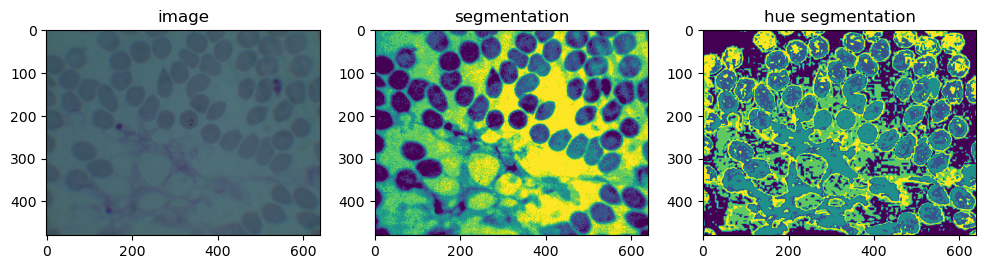

In [24]:

class FCM():
    def __init__(self, image, n_clusters, m, epsilon, max_iter):
        '''Modified Fuzzy C-means clustering
        <image>: 2D array, grey scale image.
        <n_clusters>: int, number of clusters/segments to create.
        <m>: float > 1, fuzziness parameter. A large <m> results in smaller
             membership values and fuzzier clusters. Commonly set to 2.
        <max_iter>: int, max number of iterations.
        '''

        #-------------------Check inputs-------------------
        if np.ndim(image) != 2:
            raise Exception("<image> needs to be 2D (gray scale image).")
        if n_clusters <= 0 or n_clusters != int(n_clusters):
            raise Exception("<n_clusters> needs to be positive integer.")
        if m < 1:
            raise Exception("<m> needs to be >= 1.")
        if epsilon <= 0:
            raise Exception("<epsilon> needs to be > 0")

        self.image = image
        self.n_clusters = n_clusters
        self.m = m
        self.epsilon = epsilon
        self.max_iter = max_iter

        self.shape = image.shape # image shape
        self.X = image.flatten().astype('float') # flatted image shape: (number of pixels,1) 
        self.numPixels = image.size
       
    #--------------------------------------------- 
    def initial_U(self):
        U=np.zeros((self.numPixels, self.n_clusters))
        idx = np.arange(self.numPixels)
        for ii in range(self.n_clusters):
            idxii = idx%self.n_clusters==ii
            U[idxii,ii] = 1        
        return U
    
    def update_U(self):
        '''Compute weights'''
        c_mesh,idx_mesh = np.meshgrid(self.C,self.X)
        power = 2./(self.m-1)
        p1 = abs(idx_mesh-c_mesh)**power
        p2 = np.sum((1./abs(idx_mesh-c_mesh))**power,axis=1)
        
        return 1./(p1*p2[:,None])

    def update_C(self):
        '''Compute centroid of clusters'''
        numerator = np.dot(self.X,self.U**self.m)
        denominator = np.sum(self.U**self.m,axis=0)
        return numerator/denominator
                       
    def form_clusters(self):      
        '''Iterative training'''        
        d = 100
        self.U = self.initial_U()
        if self.max_iter != -1:
            i = 0
            while True:             
                self.C = self.update_C()
                old_u = np.copy(self.U)
                self.U = self.update_U()
                d = np.sum(abs(self.U - old_u))
                print("Iteration %d : cost = %f" %(i, d))

                if d < self.epsilon or i > self.max_iter:
                    break
                i+=1
        else:
            i = 0
            while d > self.epsilon:
                self.C = self.update_C()
                old_u = np.copy(self.U)
                self.U = self.update_U()
                d = np.sum(abs(self.U - old_u))
                print("Iteration %d : cost = %f" %(i, d))

                if d < self.epsilon or i > self.max_iter:
                    break
                i+=1
        self.segmentImage()


    def deFuzzify(self):
        return np.argmax(self.U, axis = 1)

    def segmentImage(self):
        '''Segment image based on max weights'''

        result = self.deFuzzify()
        self.result = result.reshape(self.shape).astype('int')

        return self.result
    
    
def main(IS_PLOT=True,IS_SAVE=True, n_clusters=3, m=2, epsilon=5, max_iter=10):
    IMG_PATH = "images"
    OUTPUT_PATH = "output"
    OUTPUT_PLOT_PATH = os.path.join(OUTPUT_PATH,'segmentation') # path for output (plot directory)
    
    
    files = [f for f in listdir(IMG_PATH) if isfile(join(IMG_PATH, f))] # read all files in IMG_PATH
    
    for file in files:
        target_img_path = os.path.join(IMG_PATH,file)
        try:
            #--------------Lord image file--------------  
            img= cv2.imread(target_img_path, cv2.IMREAD_GRAYSCALE) # cf. 8bit image-> 0~255

            #--------------Clustering--------------  
            cluster = FCM(img, n_clusters=n_clusters, m=m, epsilon=epsilon, max_iter=max_iter)
            cluster.form_clusters()
            result=cluster.result
            
            
            #do it on the hue
            img= cv2.imread(target_img_path, 1) # cf. 8bit image-> 0~255
            hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            hue, s, v = cv2.split(hsv)
            
            cluster2 = FCM(hue, n_clusters=n_clusters, m=m, epsilon=epsilon, max_iter=max_iter)
            cluster2.form_clusters()
            result2=cluster2.result
            
            
            
                     
            #-------------------Plot and save result------------------------
            if IS_PLOT:      
                
                fig=plt.figure(figsize=(12,8),dpi=100)
            
                ax1=fig.add_subplot(1,3,1)
                ax1.imshow(img,cmap='gray')
                ax1.set_title('image')
            
                ax2=fig.add_subplot(1,3,2)
                ax2.imshow(result)
                ax2.set_title('segmentation')
                
                ax2=fig.add_subplot(1,3,3)
                ax2.imshow(result2)
                ax2.set_title('hue segmentation')
                
                plt.show(block=False)
                plt.close()
                
            if IS_SAVE:
                #makedirs(OUTPUT_PLOT_PATH)            
                seg_result_path = os.path.join(OUTPUT_PLOT_PATH,"%s.png"%(os.path.splitext(file)[0]))
                plt.imshow(result)
                plt.savefig(seg_result_path, dpi=300)
                plt.close()
                
            
        except IOError:
            print("Error")

if __name__ == '__main__':
    main(n_clusters=5, m=2, epsilon=5, max_iter=20)

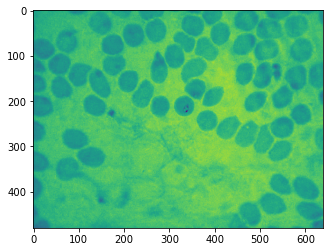

In [14]:
img = cv2.imread("images/03.jpg", 1)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
hue, s, v = cv2.split(hsv)

plt.imshow(v)
plt.show()

Felzenszwalb number of segments: 88
SLIC number of segments: 248
Quickshift number of segments: 762


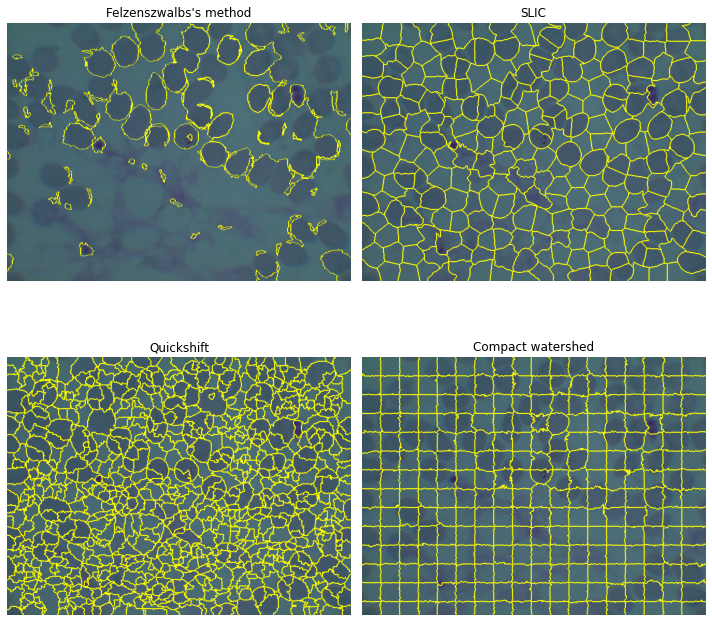

In [25]:
#https://towardsdatascience.com/fuzzy-c-means-clustering-is-it-better-than-k-means-clustering-448a0aba1ee7


import matplotlib.pyplot as plt
import numpy as np

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = cv2.imread("images/03.jpg", 1)

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1,
                     start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

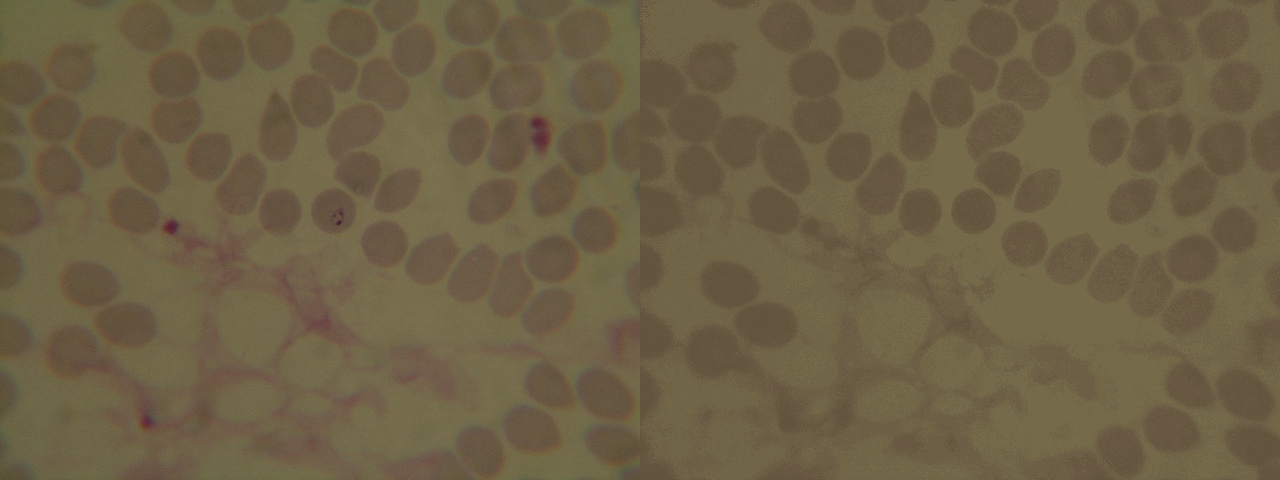

In [28]:
#FUZZY2
#https://github.com/omadson/fuzzy-c-means

import numpy as np
from PIL import Image
from fcmeans import FCM

image = Image.open('images/03.jpg')          # read image (oarsman at https://omadson.github.io/photos/)
N, M = image.size                                  # get the number of columns (N) and rows (M)
image                                              # show resized image

X = (
    np.asarray(image)                              # convert a PIL image to np array
    .reshape((N*M, 3))                             # reshape the image to convert each pixel to an instance of a data set
)

fcm = FCM(n_clusters=5)                           # create a FCM instance with 10 clusters
fcm.fit(X)                                         # fit the model

labeld_X = fcm.predict(X)                          # get the label of each data point
transformed_X = fcm.centers[labeld_X]              # pixel quantization into the centers

quatized_array = (
    transformed_X
    .astype('uint8')                               # convert data points into 8-bit unsigned integers
    .reshape((M, N, 3))                            # reshape image
)

quatized_image = Image.fromarray(np.asarray(quatized_array))   # convert array into a PIL image object
quatized_image.save('images/out.jpg') # save image

side_by_side = Image.fromarray(
    np.hstack([
        np.array(image),
        np.array(quatized_image)
    ])
)
side_by_side